# Copyright Netherlands eScience Center <br>
** Function     : Lead/Lag regression of climatological fields on AMET with in certain seasons** <br>
** Author       : Yang Liu ** <br>
** First Built  : 2018.10.22 ** <br>
** Last Update  : 2018.10.22 ** <br>
Description     : This notebook includes the result of the lag regression of climatological fields (e.g. z500, T) on AMET. It aims to unveil the relation between the climatological fields and AMET and try to illustrate how the atmosphere responses to the change of AMET.
Besides, the contribution of stationary eddy and steady mean transport are studied here too.<br>
Return Values   : jpeg <br>
Caveat! : For all the flux generated by ECMWF model, downward is positive (regardless of the standard name). The AMET is computed as the residual of net flux at TOA and surface.<br>

In [1]:
%matplotlib inline

import sys
sys.path.append("/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Scripts/META")
import numpy as np
import scipy
from netCDF4 import Dataset
import matplotlib
import matplotlib.pyplot as plt
import os
import meta.statistics
import meta.visualizer

In [2]:
# constants
constant = {'g' : 9.80616,      # gravititional acceleration [m / s2]
            'R' : 6371009,      # radius of the earth [m]
            'cp': 1004.64,      # heat capacity of air [J/(Kg*K)]
            'Lv': 2264670,      # Latent heat of vaporization [J/Kg]
            'R_dry' : 286.9,    # gas constant of dry air [J/(kg*K)]
            'R_vap' : 461.5,    # gas constant for water vapour [J/(kg*K)]
            }

In [9]:
if __name__=="__main__":
    # sample
    ################################   Input zone  ######################################
    # specify data path
    datapath = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/warehouse_met'
    datapath_ERAI_fields = '/home/ESLT0068/WorkFlow/Core_Database_AMET_OMET_reanalysis/ERAI/regression'
    output_path = '/home/ESLT0068/NLeSC/Computation_Modeling/Bjerknes/Compensation/MET_leadlag/stat_erai_oras_layer/leadlag/AMET_residual/fields_amet'
    #####################################################################################
    print ('*********************** extract variables *************************')
    dataset_ERAI_fields_200hPa = Dataset(os.path.join(datapath_ERAI_fields,
                                         'pressure_200hPa_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_fields_500hPa = Dataset(os.path.join(datapath_ERAI_fields,
                                         'pressure_500hPa_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_fields_850hPa = Dataset(os.path.join(datapath_ERAI_fields,
                                         'pressure_850hPa_ERAI_monthly_regress_1979_2016.nc'))
    dataset_ERAI_AMET = Dataset(os.path.join(datapath,
                                'era_model_subdaily_1979_2016_amet.nc'))
    dataset_ERAI_fields_flux = Dataset(os.path.join(datapath_ERAI_fields,
                                'surface_erai_monthly_regress_1979_2017_radiation.nc'))  
    # extract time series from 1979 to 2016
    # from 20N - 90N
    # 4D fields [year, month, lat, lon]
    rad_short_toa_ERAI = dataset_ERAI_fields_flux.variables['tsr'][:-1,:,:,:]
    rad_long_toa_ERAI = dataset_ERAI_fields_flux.variables['ttr'][:-1,:,:,:]
    rad_short_surf_ERAI = dataset_ERAI_fields_flux.variables['ssr'][:-1,:,:,:]
    rad_long_surf_ERAI = dataset_ERAI_fields_flux.variables['str'][:-1,:,:,:]
    SFlux_sensible_ERAI = dataset_ERAI_fields_flux.variables['sshf'][:-1,:,:,:]
    SFlux_latent_ERAI = dataset_ERAI_fields_flux.variables['slhf'][:-1,:,:,:]
    # calculate total net energy flux at TOA/surface
    net_flux_surf_ERAI = rad_short_surf_ERAI + rad_long_surf_ERAI + SFlux_sensible_ERAI + SFlux_latent_ERAI
    net_flux_toa_ERAI = rad_short_toa_ERAI + rad_long_toa_ERAI
    # geopotential height
    z_500hPa_ERAI = np.mean(dataset_ERAI_fields_500hPa.variables['z'][:] / constant['g'], 3)
    # temperature
    t_850hPa_ERAI = np.mean(dataset_ERAI_fields_850hPa.variables['t'][:], 3)
    t_500hPa_ERAI = np.mean(dataset_ERAI_fields_500hPa.variables['t'][:], 3)
    t_200hPa_ERAI = np.mean(dataset_ERAI_fields_200hPa.variables['t'][:], 3)
    # instantaneous turbulent flux
    # 3D fields [year, month, lat]
    AMET_0_ERAI = dataset_ERAI_AMET.variables['E_total_int'][:]/1000
    # other dimensions
    year_ERAI = dataset_ERAI_AMET.variables['year']
    latitude_AMET_ERAI = dataset_ERAI_AMET.variables['latitude'][:]
    longitude_AMET_ERAI = dataset_ERAI_AMET.variables['longitude'][:]
    latitude_fields_ERAI = dataset_ERAI_fields_500hPa.variables['latitude'][:]
    longitude_fields_ERAI = dataset_ERAI_fields_500hPa.variables['longitude'][:]
    # weight by latitude
    lat_weight = np.cos(2 * np.pi * latitude_fields_ERAI / 360)
    # area weighted surface flux
    net_flux_surf_ERAI_area = np.zeros(net_flux_surf_ERAI.shape, dtype=float) # unit W
    net_flux_toa_ERAI_area = np.zeros(net_flux_toa_ERAI.shape, dtype=float)
    #size of the grid box
    dx = 2 * np.pi * constant['R'] * np.cos(2 * np.pi * latitude_fields_ERAI /
                                            360) / len(longitude_fields_ERAI) 
    dy = np.pi * constant['R'] / len(latitude_fields_ERAI)
    for i in np.arange(len(latitude_fields_ERAI)):
        # change the unit to terawatt
        net_flux_surf_ERAI_area[:,:,i,:] = net_flux_surf_ERAI[:,:,i,:]* dx[i] * dy / 1E+12
        net_flux_toa_ERAI_area[:,:,i,:] = net_flux_toa_ERAI[:,:,i,:]* dx[i] * dy / 1E+12

*********************** extract variables *************************


In [11]:
    print ('Compute AMET as the residuals of net flux at TOA & surface.')
    # take the zonal mean of flux
    net_flux_surf_ERAI_int = np.sum(net_flux_surf_ERAI_area,3) / 1000 # PW
    net_flux_toa_ERAI_int = np.sum(net_flux_toa_ERAI_area,3) / 1000
    # AMET as the residual of net flux at TOA & surface
    AMET_res_ERAI = np.zeros(net_flux_surf_ERAI_int.shape)
    for i in np.arange(len(latitude_fields_ERAI)-1):
        AMET_res_ERAI[:,:,i] = -(np.sum(net_flux_toa_ERAI_int[:,:,0:i+1],2) -
                                 np.sum(net_flux_surf_ERAI_int[:,:,0:i+1],2))
    print (AMET_res_ERAI.shape)

Compute AMET as the residuals of net flux at TOA & surface.
(38, 12, 241)


In [7]:
    # calculate potential temperature
    theta_850hPa_ERAI = np.zeros(t_850hPa_ERAI.shape, dtype=float)
    theta_500hPa_ERAI = np.zeros(t_500hPa_ERAI.shape, dtype=float)
    theta_200hPa_ERAI = np.zeros(t_200hPa_ERAI.shape, dtype=float)
    theta_850hPa_ERAI[:] = t_850hPa_ERAI[:] * (850 / 1000)**0.286
    theta_500hPa_ERAI[:] = t_500hPa_ERAI[:] * (500 / 1000)**0.286
    theta_200hPa_ERAI[:] = t_200hPa_ERAI[:] * (200 / 1000)**0.286
    # weight everything by latitude
    z_500hPa_ERAI_weight = np.zeros(z_500hPa_ERAI.shape, dtype=float)
    theta_850hPa_ERAI_weight = np.zeros(theta_850hPa_ERAI.shape, dtype=float)
    theta_500hPa_ERAI_weight = np.zeros(theta_500hPa_ERAI.shape, dtype=float)
    theta_200hPa_ERAI_weight = np.zeros(theta_200hPa_ERAI.shape, dtype=float)
    for i in np.arange(len(latitude_fields_ERAI)):
        z_500hPa_ERAI_weight[:,:,i] = z_500hPa_ERAI[:,:,i] * lat_weight[i]
        theta_850hPa_ERAI_weight[:,:,i] = theta_850hPa_ERAI[:,:,i] * lat_weight[i]
        theta_500hPa_ERAI_weight[:,:,i] = theta_500hPa_ERAI[:,:,i] * lat_weight[i]
        theta_200hPa_ERAI_weight[:,:,i] = theta_200hPa_ERAI[:,:,i] * lat_weight[i]

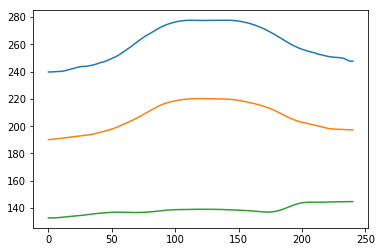

In [24]:
    plt.plot(theta_850hPa_ERAI[0,0,:],)
    plt.plot(theta_500hPa_ERAI[0,0,:])
    plt.plot(theta_200hPa_ERAI[0,0,:])

Table for an easy lead / lag analysis of seasonal data <br>

| -6 | -5 | -4 | -3 | -2 | -1 |winter| +1 | +2 | +3 | +4 | +5 | +6 |
|----|----|----|----|----|----|------|----|----|----|----|----|----|
|JJA |JAS |ASO |SON |OND |NDJ |DJF   |JFM |FMA |MAM |AMJ |MJJ |JJA |

| -6 | -5 | -4 | -3 | -2 | -1 |summer| +1 | +2 | +3 | +4 | +5 | +6 |
|----|----|----|----|----|----|------|----|----|----|----|----|----|
|DJF |JFM |FMA |MAM |AMJ |MJJ |JJA   |JAS |ASO |SON |OND |NDJ |DJF |

In [8]:
    # simple calculator for seasonal lead/lag pairing
    lag_winter = ['DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ',
                  'JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ']
    lag_summer = ['JJA', 'JAS', 'ASO', 'SON', 'OND', 'NDJ',
                  'DJF', 'JFM', 'FMA', 'MAM', 'AMJ', 'MJJ']

Be cautious about the time across the year! <br>
winter (DJF) lag -1 : x[2:] & y[1:-1]<br>
winter (DJF) lag -2 : x[2:] & y[:-2]<br>
winter (DJF) lag -3 : x[2:] & y[:-2]<br>
...<br>
winter (DJF) lag +1 : x[2:] & y[:-2]<br>
... <br>
summer (JJA) lag -1 : x & y <br>
... <br>
summer (JJA) lag -6 : x[3:] & y[2:-1] <br>
summer (JJA) lag +1 : x & y <br>
... <br>
summer (JJA) lag +6 : x[:-1] & y[1:] <br>

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********
======================   AMET + 60N & z500 + winter (DJF) ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
Create x-y plot of correlation coefficient.


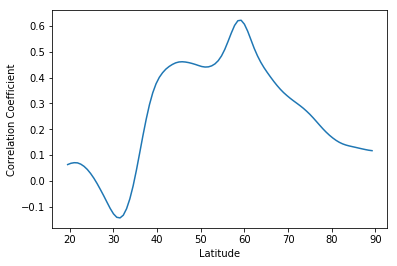

In [22]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   AMET + 60N & z500 + winter (DJF) ======================')
    lag = -3
    AMET_season_series = meta.statistics.operator.seasons(AMET_res_ERAI[:,:,40],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_season_series[2:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=30, obj='detrend')
    z500_season_series = meta.statistics.operator.seasons(z_500hPa_ERAI_weight[:,:,1:95],
                                                         span=lag_winter[lag], Dim_month=True)
    stat_z500_ERAI = meta.statistics.operator(z500_season_series[:-2,:])
    stat_z500_ERAI.anomaly(Dim_month=False)
    stat_z500_ERAI.detrend()
    stat_z500_ERAI.lowpass(window=30, obj='detrend')

    k, r, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                     stat_z500_ERAI._lowpass)
    #ticks = [-0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3]
    #ticks = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5]
    ticks = [-0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8]
    label = 'Correlation coefficient'
    meta.visualizer.plots.linearRegress(latitude_fields_ERAI[1:95], r,
                        os.path.join(output_path, 'amet_z500', 'season',
                        'spatial_ERAI_AMET_60N_lag_{}_ERAI_SST_DJF_decadal.png'.format(lag)))  

*******************  postprocess with statistical tool  *********************
***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********
======================   AMET + 60N & t + winter (DJF) ======================
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
The input data does not have the dimension of month.
The output anomaly time series only contains one dimension for time!
One time series is regressed on a 1D field.
One time series is regressed on a 1D field.
One time series is regressed on a 1D field.


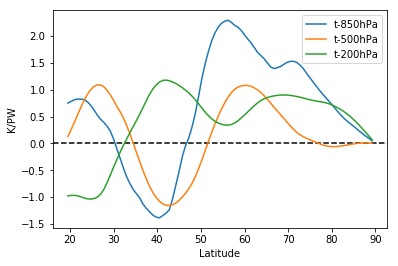

In [40]:
    print ('*******************  postprocess with statistical tool  *********************')
    print ('***********!@#$%^&* Lead/ Lag regression of ERA-Interim !@#$%^&***********')
    print ('======================   AMET + 60N & t + winter (DJF) ======================')
    lag = -4
    AMET_season_series = meta.statistics.operator.seasons(AMET_res_ERAI[:,:,40],
                                                          span='DJF', Dim_month=True)    
    stat_AMET_ERAI = meta.statistics.operator(AMET_season_series[2:])
    stat_AMET_ERAI.anomaly(Dim_month=False)
    stat_AMET_ERAI.detrend()
    stat_AMET_ERAI.lowpass(window=30, obj='detrend')
    # 850hPa
    t850_season_series = meta.statistics.operator.seasons(theta_850hPa_ERAI_weight[:,:,1:95],
                                                          span=lag_winter[lag], Dim_month=True)
    stat_t850_ERAI = meta.statistics.operator(t850_season_series[:-2,:])
    stat_t850_ERAI.anomaly(Dim_month=False)
    stat_t850_ERAI.detrend()
    stat_t850_ERAI.lowpass(window=30, obj='detrend')
    # 500hPa
    t500_season_series = meta.statistics.operator.seasons(theta_500hPa_ERAI_weight[:,:,1:95],
                                                         span=lag_winter[lag], Dim_month=True)
    stat_t500_ERAI = meta.statistics.operator(t500_season_series[:-2])
    stat_t500_ERAI.anomaly(Dim_month=False)
    stat_t500_ERAI.detrend()
    stat_t500_ERAI.lowpass(window=30, obj='detrend')
    # 200hPa    
    t200_season_series = meta.statistics.operator.seasons(theta_200hPa_ERAI_weight[:,:,1:95],
                                                         span=lag_winter[lag], Dim_month=True)
    stat_t200_ERAI = meta.statistics.operator(t200_season_series[:-2])
    stat_t200_ERAI.anomaly(Dim_month=False)
    stat_t200_ERAI.detrend()
    stat_t200_ERAI.lowpass(window=30, obj='detrend')

    k_850hPa, r_850hPa, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                            stat_t850_ERAI._lowpass)
    k_500hPa, r_500hPa, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                            stat_t500_ERAI._lowpass)  
    k_200hPa, r_200hPa, p = meta.statistics.operator.linearRegress(stat_AMET_ERAI._lowpass,
                                                            stat_t200_ERAI._lowpass)  
    fig = plt.figure()
    plt.axhline(y=0, color='k',ls='--')
    plt.plot(latitude_fields_ERAI[1:95], k_850hPa, label='t-850hPa')
    plt.plot(latitude_fields_ERAI[1:95], k_500hPa, label='t-500hPa')
    plt.plot(latitude_fields_ERAI[1:95], k_200hPa, label='t-200hPa')
    plt.xlabel("Latitude")
    #plt.xticks(np.linspace(20, 90, 11))
    plt.ylabel("K/PW")
    plt.legend()
    plt.show()
    fig.savefig(os.path.join(output_path, 'amet_t', 'season',
                'spatial_ERAI_AMET_60N_lag_{}_ERAI_t_DJF_decadal.png'.format(lag)),dpi=400)
    plt.close(fig)    